# Gaussian Processes

## From parameteric to nonparamteric models

So far, in this course, all models we have built were regressions, working in the supervised learning setting and using parametric models. We tried to describe functions with unknown parameters using Bayesian formalism.



Gaussian processes (GPs) are powerful and flexible statistical models used primarily in machine learning and statistics for regression and classification tasks. At its core, a Gaussian process is a collection of random variables, any <font color='orange'>finite subset</font> of which has a <font color='orange'>joint Multivariate</font> distribution. In simpler terms, a GP defines a <font color='orange'>distribution over functions</font> rather than individual points.

<font color='orange'>Nonparametric</font> models are statistical models where the number of parameters grows with the size of the dataset or is not fixed beforehand. This allows them to flexibly capture complex patterns in the data without making strong assumptions about the underlying distribution.

A Gaussian process is a <font color='orange'>nonparametric</font> model because it doesn't fix the number of parameters a priori, instead, it defines a distribution over functions, allowing for flexibility and adaptability to the complexity of the data.

A few key points about Gaussian processes:

- **Function Space Representation**: Unlike parametric models, which learn a fixed number of parameters, Gaussian processes define a distribution over functions. This allows them to capture uncertainty about the function being modeled.

```{margin}
Well, do assume *something* about the functions, e.g. their smoothness in the form of kernel choice. 
```
- **Flexibility**: GPs can model a wide variety of functions without assuming a specific functional form. This makes them particularly useful when dealing with complex or unknown relationships in data.

- **Bayesian Framework**: Gaussian processes are inherently Bayesian models, meaning they provide a principled way to quantify uncertainty in predictions. This is achieved by representing the posterior distribution over functions given the observed data.

- **Kernel Functions**: The choice of kernel function determines the behavior and characteristics of the GP. Common kernel functions include the radial basis function (RBF), also known as the squared exponential kernel, and the Matérn kernel, among others. These kernels encode assumptions about the smoothness and structure of the underlying function. We will see specific examples of kernels in this lecture.

- **Regression and Classification**: GPs can be used for both regression and classification tasks where GP is commonly used as a <font color='orange'>latent variable</font>.

- **Computational Considerations**: While GPs offer many advantages, they can be computationally intensive, especially as the size of the dataset grows. Various approximation methods such as sparse GPs and approximate inference techniques are used to scale Gaussian processes to larger datasets.

Now let's build the inredients which we need to understand Gaussian processes step by step.

## From Univariate to Multivariate Gaussians

### Univariate Normal distribution
```{margins}
In the chapter about distributions we used notation $X$ for a random variable and $x$ for its values. Here we will denote the random variable of interest $Y$. It will become clear soon why we need to do it.
```

Recall from previous chapters, the Univaritae normal distribution with PDF

$$
\mathcal{N}(y \mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(y - \mu)^2}{2\sigma^2}\right).
$$

To show that variable $y$ is dustributed normally with mean $\mathbb{E}[y] = \mu$ and variance $\text{Var}(y)=\sigma^2$, we use notation 
$$y \sim \mathcal{N}(\mu, \sigma^2).$$


### Reparametrization

Note, that in order to sample variable $y$ we could fisrt sample from a standard Normal variable $z \sim \mathcal{N}(0,1)$, and then perform a transformation of this variable 
$$
y = \mu + \sigma z \sim \mathcal{N}(\mu, \sigma^2).
$$

**Excersise**: prove that $\mu + \sigma z$ is indeed distributed as $\mathcal{N}(\mu, \sigma^2).$

### Multivariate Normal distribution

In the multivariate case, instead of using scalar mean and variance parameters $\mu, \sigma^2 \in \mathbb{R}$, we need to specify a vector mean $\mu \in \mathbb{R}^d$ and covariance matrix $\Sigma \in \mathbb{R}^{d \times d}.$ To write that variable $y$ follows a Multivariate Normal distribution, we use notation 
$$y \sim \mathcal{N}(\mu, \Sigma).$$

### Bivariate case

'Bivariate' means $d=2$. Hence,

$$
y =  \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}, \quad \mu = \begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix}, \quad \Sigma = \begin{pmatrix} \sigma_1^2 & \rho \sigma_1 \sigma_2 \\ \rho \sigma_1 \sigma_2  &\sigma_2^2 \end{pmatrix}.
$$

Here $\mu_i$ is the mean of component $y_i$, $\sigma_i^2$ is the variance for the $i$-th dimension, and $\rho_{ij} = \rho_{ji}$ is the *correlation* between the $i$-th and $j$-th dimensions:
$$
\mathbb{E}(y_i) = \mu_i,\\
\text{var}(y_i) = \sigma_i^2,\\
\text{corr}(y_1, y_2) = \rho_{12}.
$$
The covariance matrix tells us how the "ball" of random variables is stretched and rotated in space. Let's visualise a few examples.


In [81]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.gridspec as gridspec

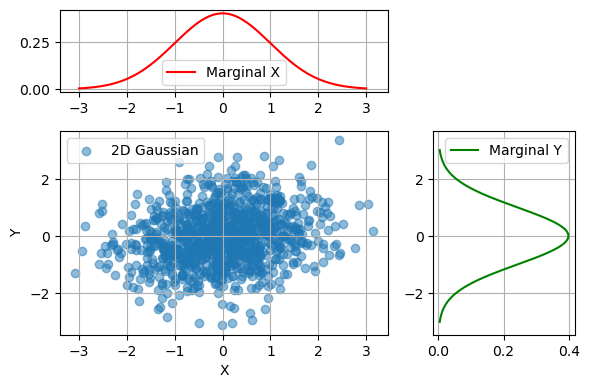

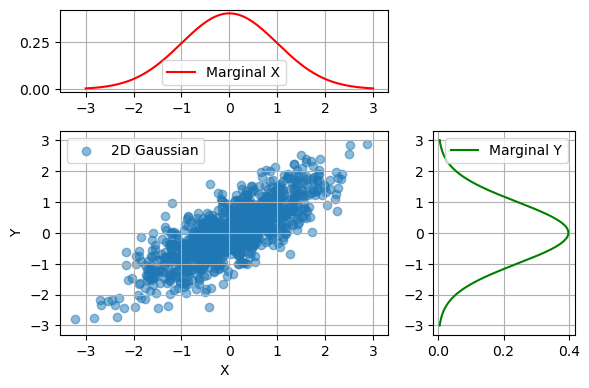

In [78]:
def plot_2d_gp(mu1, mu2, rho, sigma1=1, sigma2=1):
    mu = np.array([mu1, mu2])  # mean
    covariance = jnp.array([[sigma1**2, rho*sigma1*sigma2],[rho*sigma1*sigma2, sigma2**2]]) # covariance matrix

    # Generate data points from the 2D Gaussian distribution
    num_samples = 1000
    data = np.random.multivariate_normal(mu, covariance, num_samples)

    # Calculate marginal distributions
    x_values = np.linspace(-3, 3, 1000)
    marginal_x = norm.pdf(x_values, loc=mu[0], scale=np.sqrt(covariance[0, 0]))
    marginal_y = norm.pdf(x_values, loc=mu[1], scale=np.sqrt(covariance[1, 1]))

    # Create figure and gridspec
    fig = plt.figure(figsize=(6, 4))
    gs = fig.add_gridspec(3, 3)

    # Main plot (2D Gaussian distribution)
    ax_main = fig.add_subplot(gs[1:3, :2])
    ax_main.scatter(data[:, 0], data[:, 1], alpha=0.5, label='2D Gaussian')
    ax_main.set_xlabel('X')
    ax_main.set_ylabel('Y')
    ax_main.legend()
    ax_main.grid(True)

    # Marginal X plot
    ax_marginal_x = fig.add_subplot(gs[0, :2], sharex=ax_main)
    ax_marginal_x.plot(x_values, marginal_x, label='Marginal X', color='r')
    ax_marginal_x.legend()
    ax_marginal_x.grid(True)

    # Marginal Y plot
    ax_marginal_y = fig.add_subplot(gs[1:3, 2], sharey=ax_main)
    ax_marginal_y.plot(marginal_y, x_values, label='Marginal Y', color='g')
    ax_marginal_y.legend()
    ax_marginal_y.grid(True)

    plt.tight_layout()
    plt.show()

# Parameters for the 2D Gaussian distribution
mu1 = 0
mu2 = 0
plot_2d_gp(mu1, mu2, rho)
# How does the distribution change with different values of rho?
for rho in np.linspace(0.2,0.8, 2):
    plot_2d_gp(mu1, mu2, rho)

## Definitions

**Definition** (kernel)

$k: \mathbb{X} \times \mathbb{X} \to \mathbb{R}$ is a positive definite **kernel**, if for any finite collection $x= [x_1, ..., x_N]$ the matrix $k_{xx}$ with $[k_{xx}]_{ij}=k(x_i, x_j)$ is **positive definite**.

**Definition** (positive definite matrix)

A symmetric matrix $A \in \mathbb{R}^{N \times N}$ is called positve (semi-) definite if
$$v^T A v \ge 0$$ 
for any $v \in \mathbb{R}^N.$

**Definition** (Gaussian processes)

A **Gaussian process** is a probablity distribution over the function $f: \mathbb{X} \to \mathbb{R}$, such that every finite realisation

$$f(x) = [f(x_1), ..., f(x_N)]$$ 
is a Gaussian (multivariate normal) dsitribution

$$f_X \sim \mathcal{N}(\mu_X, k_{XX}).$$ 

## Notation

- To describe that $f$ if a GP with mean $\mu(x)$ and kernel $k(x, x')$ we will be writing

$$f(x) \sim \mathcal{GP}(\mu(x), k(x, x')).$$

- A Gaussian process is completely characterized by its **mean function** $\mu(x)$ and its **covariance function** $k(x,x'),$ which define

$$\mathbb{E}[f(x)]=\mu(x)$$
and 
$$\text{cov}[f(x), f(x')]=k(x, x').$$

## Kernels

GPs are uniquely defined by their mean and covariance functions. We will further assume that the GPs we work with have a zero mean, and, hence, we will focus on the kernels.

Kernel functions $k(x, x′)$ encode prior beliefs of data-generating latent functions. These typically include
- continuity,
- smomothness (differentialbility),
- periodicity,
- stationarity,

and so on.

The covariance functions typically have **hyperparameters** that we aim to learn from data.

Let us explore some typical covariance functions.

## Cholesky decomposition and reparametrization

Cholesky decomposition is a numerical method used to decompose a positive definite matrix into a lower triangular matrix and its conjugate transpose. For a positive definite matrix $A$, the Cholesky decomposition expresses it as:
$$A = L L^T$$
where
- $L$ is a lower triangular matrix,
- $L^T$ is the transpose of $L$.

Cholesky decomposition is particularly useful because it provides a computationally efficient way to solve linear systems of equations, including inverting matrices and calculating determinants, especially when the matrix is symmetric and positive definite.

In Gaussian processes, Cholesky decomposition is commonly used to generate samples from a multivariate Gaussian distribution. When you want to generate samples from a Gaussian process, you typically start with a covariance matrix $K$, which represents the covariance between different points in the input space. The Cholesky decomposition of this covariance matrix $K$ yields a lower triangular matrix $L$:
$$K = L L^T.$$

By multiplying this lower triangular matrix with a vector of independent standard normal variables, you can generate samples from the Gaussian process while ensuring that the resulting samples have the desired covariance structure encoded by the covariance matrix $K$. This is done because the Cholesky decomposition allows you to transform independent standard normal variables into correlated Gaussian variables according to the covariance matrix Cholesky $K$. Hence, we can either sample directly 
$$f \sim \mathcal{N}(0, \Sigma)$$
or use the reparametrization
$$f = zL \sim \mathcal{N}(0, \Sigma), \quad z \sim \mathcal{N}(0,I).$$


### Kernels - examples

### RBF

The squared exponential kernel, also known as the Gaussian kernel or the radial basis function (RBF) kernel is one of the most commonly used kernels in Gaussian process regression. It is defined as
$$k(x_i, x_j) = \sigma^2 \exp \left( -\frac{1}{2\ell^2} \|x_i - x_j\|^2 \right)$$
where

- $\sigma^2$ is the variance parameter (also called the amplitude),
- $l$ is the lengthscale parameter,
- $\|x_i - x_j\|$ is the Euclidean distance between the points $x_i$ and $x_j$.

This kernel assigns high similarity (and hence high covariance) to points that are close to each other in the input space and low similarity (and low covariance) to points that are far apart. The parameters $\sigma^2$ and $l$ control the overall variance and the rate at which the covariance decreases with distance, respectively.




In [43]:
# Define a Squared Exponential (RBF) kernel
def rbf_kernel(x1, x2, sigma=1.0, lengthscale=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    return sigma**2 * jnp.exp(-0.5 / lengthscale**2 * sq_dist)

[[1.        0.9949115 0.9798007 0.9551244 0.9216181]
 [0.9949115 1.        0.9949115 0.9798007 0.9551244]
 [0.9798007 0.9949115 1.        0.9949115 0.9798007]
 [0.9551244 0.9798007 0.9949115 1.        0.9949115]
 [0.9216181 0.9551244 0.9798007 0.9949115 1.       ]]


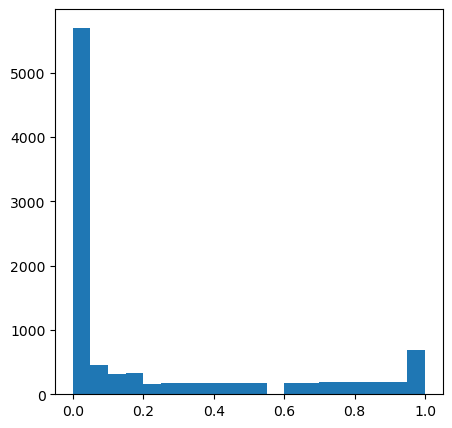

In [50]:
# Generate some 1D data
x = jnp.linspace(0, 10, 100).reshape(-1, 1)

# Compute the RBF kernel matrix
K = rbf_kernel(x, x)

# Look at element of the kernel matrix
print(K[0:5, 0:5])

# What values 
plt.figure(figsize=(5, 5))
plt.hist(K.flatten(), bins=20)
plt.show()

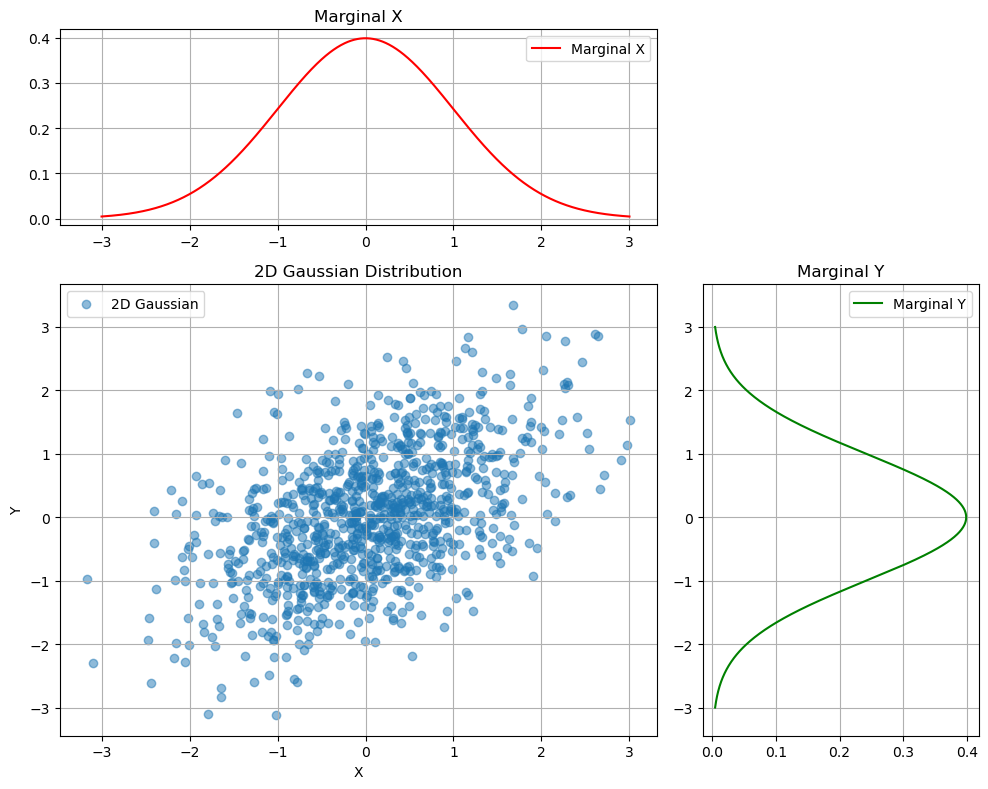

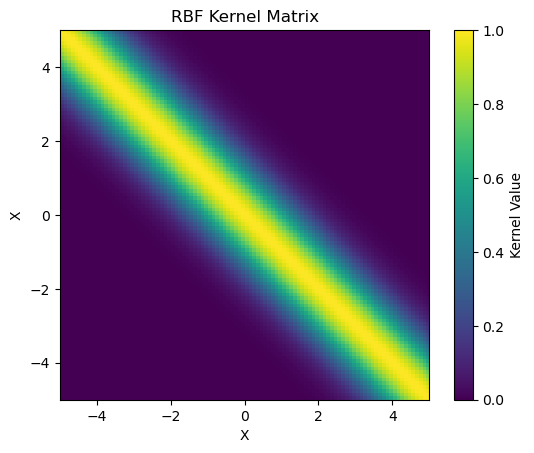

In [25]:






# Visualization
plt.imshow(K, cmap='viridis', extent=[-5, 5, -5, 5])
plt.colorbar(label='Kernel Value')
plt.title('RBF Kernel Matrix')
plt.xlabel('X')
plt.ylabel('X')
plt.show()


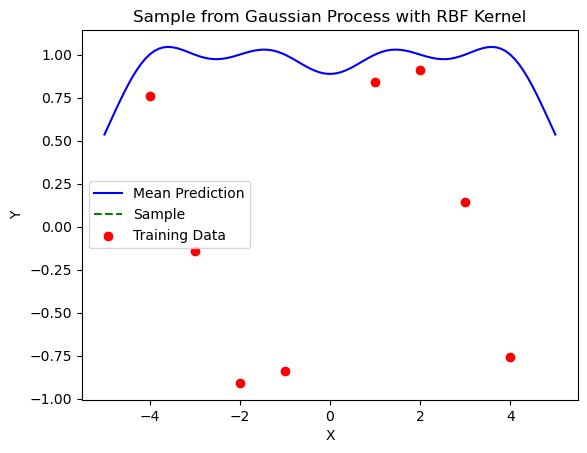

In [27]:
import jax.numpy as jnp
from jax import random
import numpy as np
import matplotlib.pyplot as plt

def rbf_kernel(x1, x2, sigma=1.0, length_scale=1.0):
    """
    Compute the Radial Basis Function (RBF) kernel matrix between two sets of points.

    Args:
    - x1 (array): Array of shape (n1, d) representing the first set of points.
    - x2 (array): Array of shape (n2, d) representing the second set of points.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.

    Returns:
    - K (array): Kernel matrix of shape (n1, n2).
    """
    sq_dist = jnp.sum(x1**2, axis=1).reshape(-1, 1) + jnp.sum(x2**2, axis=1) - 2 * jnp.dot(x1, x2.T)
    return sigma**2 * jnp.exp(-0.5 / length_scale**2 * sq_dist)

def draw_gp_sample(rng_key, X_pred, X_train, kernel_func, sigma=1.0, length_scale=1.0, noise=1e-6):
    """
    Draw a sample from a Gaussian process with given kernel.

    Args:
    - rng_key: JAX random key.
    - X_pred (array): Array of shape (n_pred, d) representing the prediction points.
    - X_train (array): Array of shape (n_train, d) representing the training points.
    - kernel_func (function): Function to compute the kernel.
    - sigma (float): Variance parameter.
    - length_scale (float): Length-scale parameter.
    - noise (float): Observation noise.

    Returns:
    - f_pred (array): Array of shape (n_pred,) representing the sampled function values at prediction points.
    """
    # Compute the kernel matrices
    K_xx = kernel_func(X_train, X_train, sigma, length_scale)
    K_xpred_x = kernel_func(X_pred, X_train, sigma, length_scale)
    K_xpred_xpred = kernel_func(X_pred, X_pred, sigma, length_scale)

    # Add observation noise
    K_xx += noise * jnp.eye(X_train.shape[0])

    # Compute the mean and covariance of the predictive distribution
    L = jnp.linalg.cholesky(K_xx)
    alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L, jnp.ones(X_train.shape[0])))
    f_mean = jnp.dot(K_xpred_x, alpha)
    v = jnp.linalg.solve(L, K_xpred_x.T)
    f_cov = K_xpred_xpred - jnp.dot(v.T, v)

    # Draw a sample from the predictive distribution
    f_pred = random.multivariate_normal(rng_key, f_mean, f_cov)
    return f_pred, f_mean

# Set random seed
key = random.PRNGKey(0)

# Define the kernel parameters
sigma = 1.0
length_scale = 1.0

# Define the training data
X_train = jnp.array([-4, -3, -2, -1, 1, 2, 3, 4]).reshape(-1, 1)
Y_train = jnp.sin(X_train)

# Define the prediction points
X_pred = jnp.linspace(-5, 5, 100).reshape(-1, 1)

# Draw a sample from the GP
f_sample, f_mean = draw_gp_sample(key, X_pred, X_train, rbf_kernel, sigma, length_scale)

# Plot the mean prediction
plt.plot(X_pred, f_mean, color='blue', label='Mean Prediction')

# Plot the sample
plt.plot(X_pred, f_sample, color='green', linestyle='--', label='Sample')

# Plot the training data
plt.scatter(X_train, Y_train, color='red', label='Training Data')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sample from Gaussian Process with RBF Kernel')
plt.legend()
plt.show()
